In [28]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
!gdown --id 17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X
From (redirected): https://drive.google.com/uc?id=17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X&confirm=t&uuid=1f0cd713-c013-4c38-aa86-2038afb3f399
To: /content/dataset.zip
100% 81.0M/81.0M [00:01<00:00, 66.0MB/s]


In [21]:
import zipfile

current_dir = os.getcwd()
local_zip = './dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [22]:
# Set the dataset folder path
dataset_folder = 'dataset'

# Get the list of class folders
class_folders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

# Create lists to store the image file paths and their corresponding labels
image_files = []
labels = []

# Iterate through each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_folder, class_folder)
    image_files_in_class = [os.path.join(class_folder_path, f) for f in os.listdir(class_folder_path) if f.endswith('.jpg')]
    image_files.extend(image_files_in_class)
    labels.extend([class_folder] * len(image_files_in_class))

# Convert the lists to numpy arrays
image_files = np.array(image_files)
labels = np.array(labels)

# Split the data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.5, random_state=42, stratify=labels)

# Create train and test folders if they don't exist
if not os.path.exists(os.path.join(dataset_folder, 'train')):
    os.makedirs(os.path.join(dataset_folder, 'train'))
if not os.path.exists(os.path.join(dataset_folder, 'test')):
    os.makedirs(os.path.join(dataset_folder, 'test'))

# Move images to train and test folders
for file in train_files:
    class_folder = os.path.basename(os.path.dirname(file))
    if not os.path.exists(os.path.join(dataset_folder, 'train', class_folder)):
        os.makedirs(os.path.join(dataset_folder, 'train', class_folder))
    os.rename(file, os.path.join(dataset_folder, 'train', class_folder, os.path.basename(file)))

for file in test_files:
    class_folder = os.path.basename(os.path.dirname(file))
    if not os.path.exists(os.path.join(dataset_folder, 'test', class_folder)):
        os.makedirs(os.path.join(dataset_folder, 'test', class_folder))
    os.rename(file, os.path.join(dataset_folder, 'test', class_folder, os.path.basename(file)))

In [46]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2
)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 242 images belonging to 64 classes.
Found 243 images belonging to 64 classes.


In [47]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 242
Testing samples: 243


In [ ]:
print("Class Indicate", train_generator.class_indices)

Class Indicate {'Astor Chocolate 40g': 0, 'Astor Matcha 40g': 1, 'Bear Brand Susu Steril 189ml': 2, 'Beng-Beng Share It 95g': 3, 'Buavita Apel 245ml': 4, 'Buavita Jambu 245ml': 5, 'Buavita Jeruk 245ml': 6, 'Buavita Korean White Peach 245ml': 7, 'Buavita Leci 245ml': 8, 'Buavita Mangga 245ml': 9, 'Chimi Jagung Bakar 50g': 10, 'Chitato Lite Rumput Laut 68g': 11, 'Cimory Fresh Milk Almond 250ml': 12, 'Cimory Fresh Milk Blueberry 250ml': 13, 'Cimory Fresh Milk Cashew 250ml': 14, 'Cimory Fresh Milk Choco Malt 250ml': 15, 'Cimory Fresh Milk Strawberry 250ml': 16, 'Cimory Yogurt Drink Blueberry 240ml': 17, 'Cimory Yogurt Drink Low Fat Strawberry & Mango 240ml': 18, 'Cimory Yogurt Drink Lychee 240ml': 19, 'Cimory Yogurt Drink Strawberry 240ml': 20, 'Coca Cola Original 390ml': 21, 'Coca Cola Zero Sugar 390ml': 22, 'Fanta Rasa Jeruk 390ml': 23, 'Fanta Rasa Stroberi 390ml': 24, 'French Fries 2000 62g': 25, 'Garuda Kacang Atom Original 17g': 26, 'Hello Panda Chocolate Cream 42g': 27, 'Hello Panda 

In [48]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
train_generator.class_weights = class_weights
test_generator.class_weights = class_weights

In [54]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(229, 229, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes_train), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 227, 227, 32)      896       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 113, 113, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (None, 111, 111, 64)      18496     
                                                                 
 conv2d_76 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_77 (Conv2D)          (None, 52, 52, 128)     

In [55]:
# Train the model
history = model.fit(train_generator,
                    epochs=100,
                    batch_size=32,
                    validation_data=test_generator,
                    verbose=1)

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 4.2095 - accuracy: 0.0000e+00 - val_loss: 4.1300 - val_accuracy: 0.0165
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 4.1420 - accuracy: 0.0207 - val_loss: 4.1255 - val_accuracy: 0.0288
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 4.1263 - accuracy: 0.0248 - val_loss: 4.1061 - val_accuracy: 0.0370
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 4.1135 - accuracy: 0.0413 - val_loss: 4.0831 - val_accuracy: 0.0288
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 4.0819 - accuracy: 0.0331 - val_loss: 4.0506 - val_accuracy: 0.0535
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 4.0452 - accuracy: 0.0496 - val_loss: 4.0047 - val_accuracy: 0.0576
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 3.9959 - accuracy: 0.0496 - val_loss: 3.9724 - val_accuracy: 0.0494
Epoch 8/100
8/8 [============

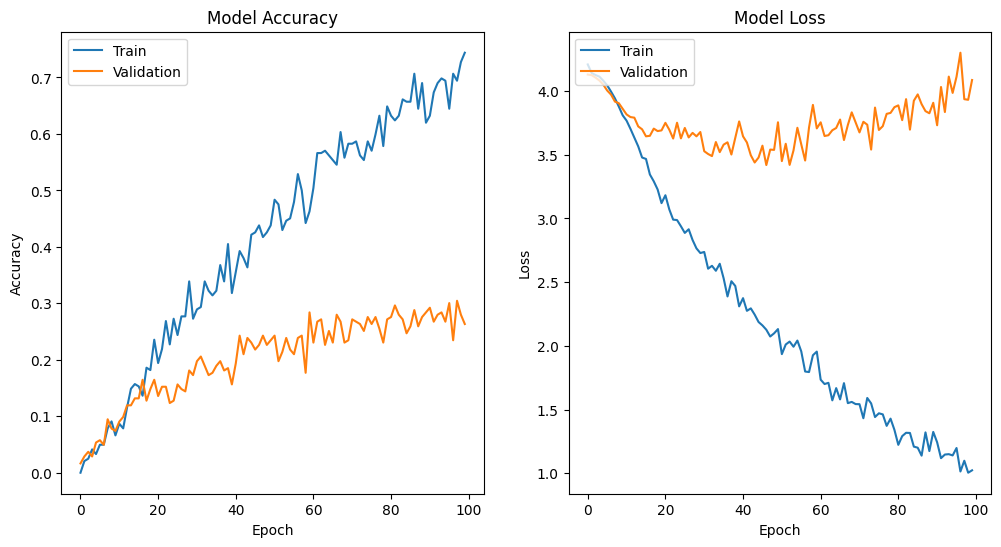

In [56]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Saving images (1).jpeg to images (1).jpeg
User uploaded file "images (1).jpeg" with length 12470 bytes
1/1 [==============================] - 1s 506ms/step


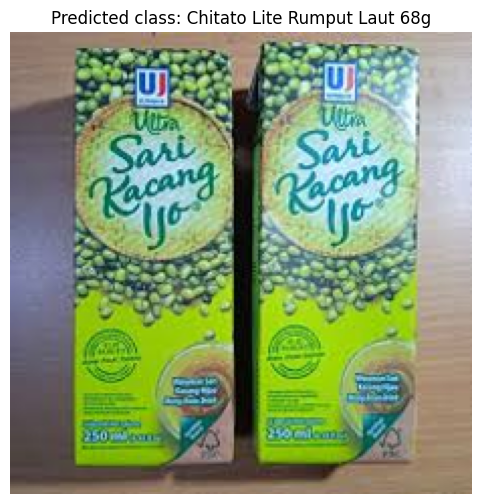

In [57]:
# Test the model on a new image
import io
from PIL import Image
from google.colab.files import upload
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((229, 229))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

In [58]:
#save your model in the SavedModel format
export_dir = 'modelscratch/saved_model'
tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the model.
with open('scratch_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [61]:
!mv scratch_model.tflite /content/drive/MyDrive/model